In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
from datetime import date
from tqdm.notebook import tqdm_notebook
import math

In [2]:
def get_data(assets, start_date, end_date, time_interval):
    return yf.download(assets, 
                          start = start_date, 
                          end = end_date,
                          interval = time_interval,
                          threads = True,
                          progress = False)['Adj Close']

In [3]:
assets  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX", "Amc"]


# ----------- DATES ------
start_train_date = '2020-01-01'
end_train_date = '2021-01-01'
start_test_date = end_train_date
end_test_date = date.today()
interval = "1d"


all_stocks = get_data(assets, '2014-01-01', date.today(), "1d")

returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns = returns.iloc[1: , :]

# all_stocks

Initialisation des variables

In [4]:
def init(Money, Pos_max_par_actif):
    
    global X, cash, argent_gagne, couts_transaction, s, argent_fait, pf_value, pos, pos2, bounds, nb_actifs
    
    # Variables utilisées dans l'algorithme

    cash = Money
    win = 0
    argent_gagne = 0
    cout = 0
    couts_transaction = 0
    s = 0
    nb_actifs = returns.shape[1]
    argent_fait = [Money]
    pf_value = 0
    X = []

    # pos = portefeuille initialement vide
    pos = np.array([0 for i in range(nb_actifs)])
    pos2 = np.array([0 for i in range(nb_actifs)])
    
    # Every stock can get any position from 0 to Pos_max_par_actif
    bounds = Bounds(0, Pos_max_par_actif)


Fonctions objectif et coûts de transaction

In [5]:
def objective_cov(pos):
    global s
    
    s = pos@covar_matrix@pos - alpha*expected_returns@pos
    
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(returns.mean()@pos) + '\033[0m')
    # print('\033[94m'+"Somme des positions: "+str(vp@pos.T)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")
    return s

def objective_corr(pos):
    global s
    
    s = pos@correl_matrix@pos - alpha*expected_returns@pos
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(returns.mean()@pos) + '\033[0m')
    # print('\033[94m'+"Somme des positions: "+str(vp@pos.T)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")
    return s

def TC(pos,pos2):
    return lamb*(np.sum(np.array([np.abs(pos2[i]-pos[i]) for i in range(nb_actifs)])))


Import des données roulantes à l'étape i

In [6]:
def import_donnees(etape):
    global expected_returns, correl_matrix, covar_matrix, vp, vp2, X
    
    # import des données roulantes, on calcule à partir des données de l'année précédente
    log_returns = returns.iloc[etape:253+etape , :]
    # calcul des expected returns (on prend une période plus courte)
    expected_returns = log_returns.iloc[-jours_returns:: ,:].mean()

    # calcul de la matrice de covariance
    covar = log_returns.cov().copy()
    covar_matrix = covar.to_numpy()
    
    correl = log_returns.corr().copy()
    correl_matrix = correl.to_numpy()

    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+etape::].values[0]
    vp2 = all_stocks[253+etape+periode_trades::].values[0]

    X.append(str(returns.iloc[253+etape].name).split()[0])

Calcul de l'optimisation roulante

In [7]:
def compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades, debug=True):
    
    global pf_value, pos, pos2, argent_gagne, cout, win, cash, couts_transaction
    
    init(Money, Pos_max_par_actif)
    
    if debug:
        print("Argent injecté au départ:", Money)

    try:
        for i in tqdm_notebook(range(100)):

            # actualisation des positions
            pos = pos2

            # actualisation des contraintes
            cons = ({"type":"ineq", "fun": lambda x: Money - np.sum(np.array(x)) }, 
                # The positions must invest no more than the initial money.
                # This constraints says that the inequalities (ineq) must be non-negative.
                {"type": "ineq", "fun": lambda x: -(TC(pos,x) + np.sum((x-pos))) + cash },
                {"type" : "ineq", "fun": lambda x: x.dot(expected_returns) - TC(pos,x)},
                # The expected daily return of our portfolio and we want to be at greater than 0.003
                #{"type": "ineq", "fun": lambda x: -np.sum(returns.mean()*x)+1})
               )

            # calcul des returns, de la matrice de variance, des vecteurs prix
            import_donnees(i*periode_trades)

            # calcul du vecteur position
            p = minimize(objective_cov, pos, 
                     method = "SLSQP", 
                     bounds= bounds,
                     constraints= cons, options={'maxiter': 300, 'ftol': 1e-09})

            pos2 = p.x # les positions prises en fin de journée

            cout = TC(pos,pos2)
            couts_transaction += cout
            pf2_value = np.sum(pos2)

            cash_restant = pf_value + cash - (cout + pf2_value) 

            cash = cash_restant # l'argent que l'algo décide de ne pas investir
            
            if debug:
                print("\n","Etape {}:".format(i))
                
                # affichage des valeurs numériques
                print("cash :", cash.round(6))
                print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
                print('\033[94m'+"Somme des positions: "+str(pf2_value)+'\033[0m')
                # print(f"Les valeurs  du vecteur poids sont:{pos2.round(3)}")
                print(f"La valeur de la fonction objectif:{s.round(3)}")

            # mise à jour du vecteur des positions à chaque actualisation des prix
            pos = pos2
            pos2 = np.array([pos[i]*vp2[i]/vp[i] for i in range(nb_actifs)])
            Money = np.sum(pos2) + cash
            argent_fait.append(Money)
            win = np.sum(pos2)-np.sum(pos)
            argent_gagne += win
            pf_value = np.sum(pos2)
            if debug:
                print('\033[95m'+"Argent généré sans TC : "+str(win)+'\033[0m')
                print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
                print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")

            """try :
                assert (np.round(1000 + argent_gagne - couts_transaction, 6) == np.round(Money,6))
            except AssertionError :
                print(np.round(1000 + argent_gagne - couts_transaction, 6))
                print(np.round(Money,6))
                break"""
        if debug:
            print("\n","fin du calcul")
    except IndexError :
        if debug:
            print("\n","fin du calcul")
        
# reste()

  0%|          | 0/100 [00:00<?, ?it/s]

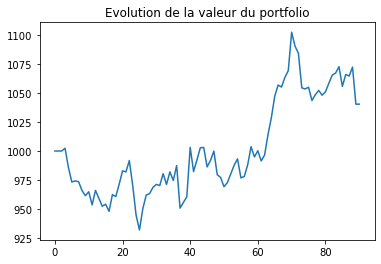

In [8]:
# Paramètres modifiables

lamb = 0.005 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
alpha = 10 # importance accordée à l'expected return
Money = 1000 # argent alloué pour l'investissement initial
Pos_max_par_actif = 1000 # quantité maximale d'argent investi par actif
jours_returns = 20 # les n derniers jours qui servent pour calculer les expected returns
periode_trades = 20 # le nombre de jours ouvrés qui séparent chaque décision


compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades, False)

plt.plot(argent_fait)
plt.title("Evolution de la valeur du portfolio")
plt.show()

# argent_fait

Calcul du drawdown

In [9]:
drawdown = -math.inf
maxi = -math.inf
mini = math.inf
i = 0
details = False # afficher plus de détails

for x in argent_fait:
    if x > maxi:
        if details :
            print("max atteint en{}:{}".format(i, argent_fait[i]) )
        maxi = x
        mini = math.inf
    elif x < mini:
        if details:
            print("min atteint en{}:{}".format(i, argent_fait[i]) )
        mini = x
        drawdown = max(drawdown, (maxi-mini)/maxi)
    i+=1

drawdown

0.07005308349098863

In [10]:
pos.round(3)

array([0.0000e+00, 0.0000e+00, 4.8055e+01, 0.0000e+00, 8.3415e+01,
       0.0000e+00, 2.2170e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
       4.6780e+00, 0.0000e+00, 3.7601e+01, 0.0000e+00, 8.0117e+01,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 0.0000e+00])

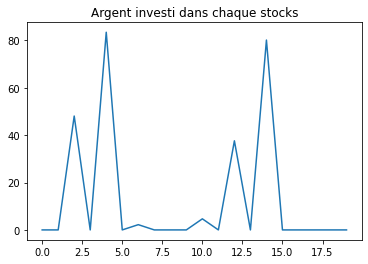

L'argent est le plus investi dans l'action: EWJ


In [11]:
plt.plot([pos[i] for i in range(len(pos))])
plt.title("Argent investi dans chaque stocks")
plt.show()
print("L'argent est le plus investi dans l'action: "+assets[np.argmax(pos)])

In [12]:
# Le returns avec une telle repartition de portefeuille est de:
returns.mean()

AMC     -0.000016
BWX     -0.000013
DBC      0.000020
EEM      0.000091
EWJ      0.000152
GLD      0.000226
IEF      0.000120
INTC     0.000386
QQQ      0.000668
REM      0.000210
RWX      0.000077
SCZ      0.000204
SPY      0.000471
TIP      0.000153
TLT      0.000226
TSM      0.000973
TWTR    -0.000318
VGK      0.000124
VNQ      0.000384
VWUSX    0.000556
dtype: float64

In [17]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([assets,pos])
for i in range(len(assets)):
    print(assets[i],pos[i].round(3))

Nombre d'action acheté pour chaque symbols: 
SPY 0.0
QQQ 0.0
VGK 48.055
SCZ 0.0
EWJ 83.415
EEM 0.0
REM 2.217
VNQ 0.0
RWX 0.0
TIP 0.001
IEF 4.678
TLT 0.0
BWX 37.601
DBC 0.0
GLD 80.117
twtr 0.0
intc 0.0
tsm 0.0
VWUSX 0.001
Amc 0.0
